---
title: "2.2-Support Vector Regression"
author: "Ahmed Aredah"
date: "10.26.2023"
output: html_document
editor: visual
categories:
    Regression
format:
  html: 
    code-tools:
      source: true
      toggle: false
      caption: none
    
---

## Mathematical Formulation

Support Vector Regression (SVR) is used to model the relationship between a dependent variable \(y\) and multiple independent variables \(x_1, x_2, \ldots, x_n\). The objective of SVR is to find a function \(f(x)\) that has at most \(\epsilon\) deviation from the actually obtained targets \(y_i\) for all the input samples \(x_i\), and at the same time is as flat as possible.

The SVR function can be mathematically represented as follows:
\begin{equation}
f(x) = \langle w, x \rangle + b
\end{equation}

where:

- \(w\) is the weight vector.

- \(x\) is the input vector.

- \(b\) is the bias.

- \(\langle w, x \rangle\) represents the dot product of \(w\) and \(x\).

The goal of SVR is to find the optimal values of \(w\) and \(b\) that minimize the following cost function:
\begin{equation}
\frac{1}{2} \|w\|^2 + C \sum_{i=1}^{m} \left(\max(0, |y_i - \langle w, x_i \rangle - b| - \epsilon)\right)
\end{equation}

where:

- \(C\) is the regularization parameter, which controls the trade-off between achieving a low training error and a low testing error.

- \(\epsilon\) is the insensitivity tube within which no penalty is associated in the training loss function with points predicted within a distance \(\epsilon\) from the actual value.

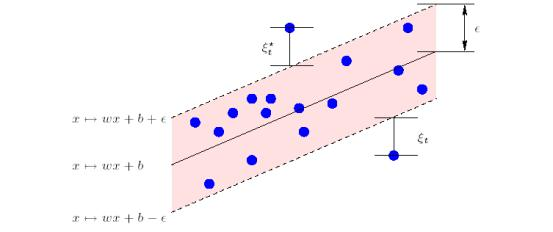



### Kernel Trick

In cases where the relationship between the dependent and independent variables is non-linear, SVR can be extended to handle non-linear relationships using the kernel trick. The kernel trick involves transforming the input space into a higher-dimensional space where a linear relationship between the dependent and independent variables can be found. Mathematically, this can be represented as follows:
\begin{equation}
f(x) = \langle w, \phi(x) \rangle + b
\end{equation}

where:

- \(\phi(x)\) is the transformed input vector.

The cost function becomes:
\begin{equation}
\frac{1}{2} \|w\|^2 + C \sum_{i=1}^{m} \left(\max(0, |y_i - \langle w, \phi(x_i) \rangle - b| - \epsilon)\right)
\end{equation}

A common kernel used in SVR is the Gaussian Radial Basis Function (RBF) kernel, which is defined as follows:
\begin{equation}
K(x_i, x_j) = \exp\left(-\frac{\|x_i - x_j\|^2}{2\sigma^2}\right)
\end{equation}

where:

- \(K(x_i, x_j)\) is the kernel function that computes the dot product \(\langle \phi(x_i), \phi(x_j) \rangle\).

- \(\sigma\) is the bandwidth parameter of the RBF kernel.


## Application on Cars selling Dataset

For this blog post, we will be applying SVR to predict car selling prices based on various features such as milage, power, etc. The dataset used here will be the same as the one used for the Linear Regression model to compare the resultant model.

In [1]:
#import required libraries
import pandas as pd
import os
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

#inline plots
%matplotlib inline

# Set Seaborn style to "whitegrid" for a white background with grid lines
sns.set_style("whitegrid")

#supress warnings!
warnings.simplefilter(action='ignore', category=Warning)
# Set the display option to show all columns
pd.set_option('display.max_columns', None)

print("required libraries loaded successfully!")

required libraries loaded successfully!


Let's quickly load the dataset and clean it as we did in the linear regression post

In [2]:
#| echo: false
# Set the background color to black and axis label color to white
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['legend.edgecolor'] = 'white'

In [3]:
# Load the cars dataset
cars = pd.read_csv("https://raw.githubusercontent.com/AhmedAredah/MachineLearningBasics/main/data/cars.csv")

# Drop rows where any cell contains NA or NAN 
cars = cars.dropna()

# List of columns to process
columns_to_process = ['mileage', 'engine', 'max_power']

for column in columns_to_process:
    # Convert the column to string type
    cars[column] = cars[column].astype(str)
    
    # Extract the first numerical value (assumes format is "value unit")
    cars[column] = cars[column].str.split().str[0]
    
    # Convert those values to float, set others to NaN if they can't be converted
    cars[column] = pd.to_numeric(cars[column], errors='coerce')

import re

# Function to extract the numeric part before 'Nm'
def extract_torque_value(s):
    match = re.search(r'(\d+)Nm', s)
    return float(match.group(1)) if match else None

# Apply the function to the torque column
cars['torque'] = cars['torque'].apply(extract_torque_value)
cars.dropna()
cars = cars.drop(["year", "seats", "max_power"], axis=1)

# Preprocessing: One-hot encode categorical variables
categorical_columns = ['fuel', 'seller_type', 'transmission', 'owner']
one_hot = OneHotEncoder(drop='first', sparse=False)  # drop='first' to avoid multicollinearity
encoded_features = one_hot.fit_transform(cars[categorical_columns])
encoded_df = pd.DataFrame(encoded_features, columns=one_hot.get_feature_names_out(categorical_columns))

# Concatenate encoded features with the original dataframe
cars = pd.concat([cars, encoded_df], axis=1)

# Drop the original categorical columns and other non-numeric columns
cars = cars.drop(columns=categorical_columns + ['name', 'torque'])

# Define predictors (X) and target variable (y)
X = cars.drop('selling_price', axis=1)
y = cars['selling_price']
X = X.fillna(X.mean())
y = y.fillna(y.mean())

In [4]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Support Vector Regression model
svr_reg = SVR(kernel='linear')
svr_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svr_reg.predict(X_test)

# Evaluate the model's performance
r2 = r2_score(y_test, y_pred)
print(f"R^2 (coefficient of determination): {r2:.2f}")
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

R^2 (coefficient of determination): 0.27
Mean Squared Error: 479844290934.03


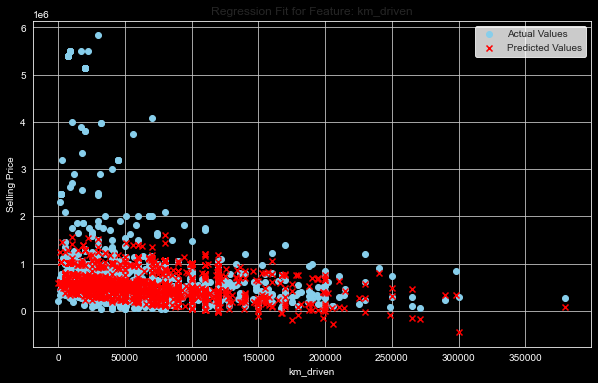

In [5]:
# Selecting the first feature for demonstration
feature_index = 0
feature_name = X.columns[feature_index]

plt.figure(figsize=(10, 6))

# Scatter plot of actual vs. predicted
plt.scatter(X_test[feature_name], y_test, color='skyblue', label='Actual Values')
plt.scatter(X_test[feature_name], y_pred, color='red', marker='x', label='Predicted Values')


plt.title('Regression Fit for Feature: ' + feature_name)
plt.xlabel(feature_name)
plt.ylabel('Selling Price')
plt.legend()
plt.grid(True)
plt.show()

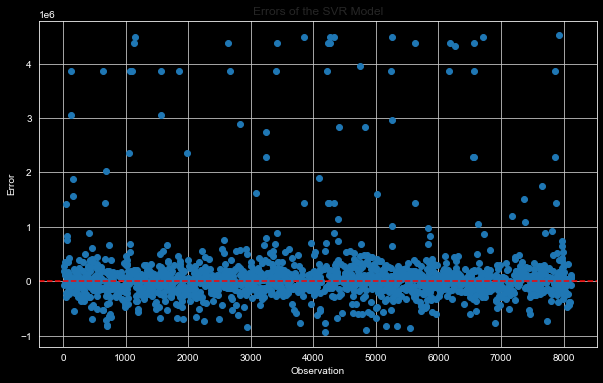

In [6]:
# Calculate the errors
errors = y_test - y_pred

# Plot the errors
plt.figure(figsize=(10, 6))
plt.plot(errors, marker='o', linestyle='')
plt.axhline(0, color='r', linestyle='--')
plt.title('Errors of the SVR Model')
plt.xlabel('Observation')
plt.ylabel('Error')
plt.grid(True)
plt.show()

Looking at the "Errors of the SVR Model" plot, the following observations can be made:

- Heteroscedasticity: The spread of the residuals is not constant across the range of observations. There's a notable concentration of residuals around the zero-error line, but the spread increases for certain sections of the observation range. This suggests the presence of heteroscedasticity, which means the model's performance is inconsistent across different segments of the data.

- Outliers: There are several points that lie far from the zero-error line, indicating potential outliers in the dataset. These outliers can have a significant impact on the model's overall performance and might be the cause of some of the model's inaccuracies.

- Trend in Residuals: While there's a central concentration of residuals around the zero line, some scattered patterns can be observed, suggesting potential non-linearities or other trends in the data that the current SVR model might not be capturing.

- Bias: The majority of the residuals seem to be concentrated slightly above and below the zero-error line, but the distribution appears fairly symmetric. This suggests that there's no significant systematic bias in the model's predictions.

- Scale of Errors: Some errors are notably large, reaching values in the millions. This indicates that for certain observations, the SVR model's predictions can be significantly off the mark.

In conclusion, while the SVR model seems to perform adequately for a majority of the observations (as indicated by the residuals clustered around the zero line), there's room for improvement, especially considering the presence of outliers, the increasing spread of residuals in certain observation ranges, and potential trends in the errors. Adjustments to the model, such as addressing outliers, feature engineering, and hyperparameter tuning, could lead to better and more consistent performance.

---

#### Second regression model with transformation
now, lets transform the selling price and km_driven columns using log() function and create a new regression model

In [7]:
cars['selling_price'] = np.log1p(cars['selling_price'])
cars['km_driven'] = np.log1p(cars['km_driven'])

# Define predictors (X) and target variable (y)
X = cars.drop('selling_price', axis=1)
y = cars['selling_price']
X_train = X_train.dropna()
y_train = y_train[X_train.index]  # Keep corresponding y values

In [8]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Drop rows with NaN values from X_train
X_train = X_train.dropna()
# Synchronize y_train with the updated X_train
y_train = y_train.loc[X_train.index]
X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

# Create and train the Support Vector Regression model
svr_reg = SVR(kernel='linear',) 
svr_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svr_reg.predict(X_test)

# Evaluate the model's performance
r2 = r2_score(y_test, y_pred)
print(f"R^2 (coefficient of determination): {r2:.2f}")
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

R^2 (coefficient of determination): 0.02
Mean Squared Error: 0.66


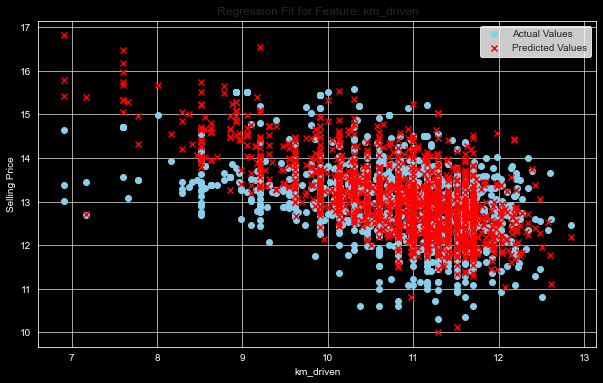

In [9]:
# Selecting the first feature for demonstration
feature_index = 0
feature_name = X.columns[feature_index]

plt.figure(figsize=(10, 6))

# Scatter plot of actual vs. predicted
plt.scatter(X_test[feature_name], y_test, color='skyblue', label='Actual Values')
plt.scatter(X_test[feature_name], y_pred, color='red', marker='x', label='Predicted Values')


plt.title('Regression Fit for Feature: ' + feature_name)
plt.xlabel(feature_name)
plt.ylabel('Selling Price')
plt.legend()
plt.grid(True)
plt.show()

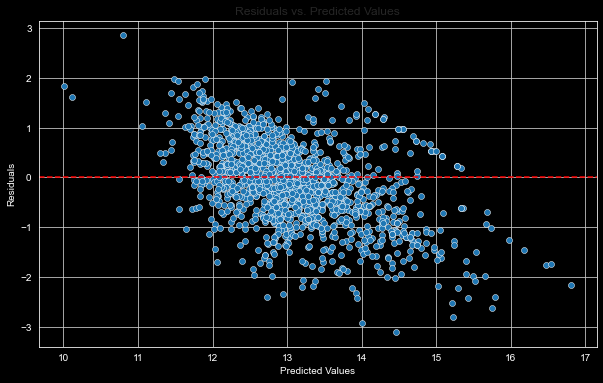

In [10]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10,6))
sns.scatterplot(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

Observing the "Residuals vs. Predicted Values" plot, we can make the following comments:

- Homoscedasticity: The residuals seem to be spread relatively evenly around the zero line for most of the predicted values. This suggests that the model's errors are generally consistent across the range of predicted values, indicating homoscedasticity. This is a desirable property as it means the model's performance is consistent across different predicted values.

- No Clear Bias: The residuals are dispersed both above and below the zero line in a relatively symmetric fashion. This suggests that the model does not exhibit a clear systematic bias in either overestimating or underestimating the target values.

- Possible Non-Linearity: The somewhat "U" shaped pattern of the residuals suggests that there might be some non-linear relationships in the data that the model is not fully capturing. This indicates that a model with a non-linear transformation or a different type of model might perform better.

- Outliers: There are some residuals that deviate significantly from the zero line, especially on the lower and upper end of the predicted values. These could be outliers or instances where the model's predictions are considerably inaccurate.

- Density of Residuals: A dense clustering of residuals around the zero line, especially in the mid-range of predicted values, suggests that the model is making accurate predictions for a large portion of the data.

In summary, the model appears to be doing a reasonably good job for many of the predicted values, as indicated by the dense cluster of residuals around the zero line. However, the curvature observed in the residuals' pattern hints at potential non-linearities in the data that might be addressed with further feature engineering, model adjustments, or considering a different modeling approach. The presence of significant outliers also indicates areas where the model's predictions could be improved.

---

#### Third regression model with transformation
now, lets try to use a different kernel

In [11]:
cars['selling_price'] = np.log1p(cars['selling_price'])
cars['km_driven'] = np.log1p(cars['km_driven'])

# Define predictors (X) and target variable (y)
X = cars.drop('selling_price', axis=1)
y = cars['selling_price']
X_train = X_train.dropna()
y_train = y_train[X_train.index]  # Keep corresponding y values

In [12]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Drop rows with NaN values from X_train
X_train = X_train.dropna()
# Synchronize y_train with the updated X_train
y_train = y_train.loc[X_train.index]
X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

# Create and train the Support Vector Regression model
svr_reg = SVR(kernel='poly',) 
svr_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svr_reg.predict(X_test)

# Evaluate the model's performance
r2 = r2_score(y_test, y_pred)
print(f"R^2 (coefficient of determination): {r2:.2f}")
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

R^2 (coefficient of determination): 0.23
Mean Squared Error: 0.00


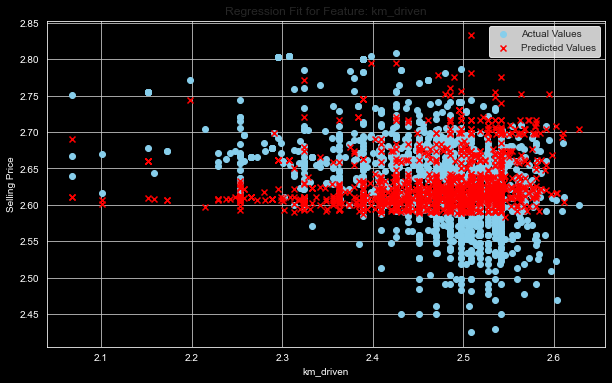

In [13]:
# Selecting the first feature for demonstration
feature_index = 0
feature_name = X.columns[feature_index]

plt.figure(figsize=(10, 6))

# Scatter plot of actual vs. predicted
plt.scatter(X_test[feature_name], y_test, color='skyblue', label='Actual Values')
plt.scatter(X_test[feature_name], y_pred, color='red', marker='x', label='Predicted Values')


plt.title('Regression Fit for Feature: ' + feature_name)
plt.xlabel(feature_name)
plt.ylabel('Selling Price')
plt.legend()
plt.grid(True)
plt.show()

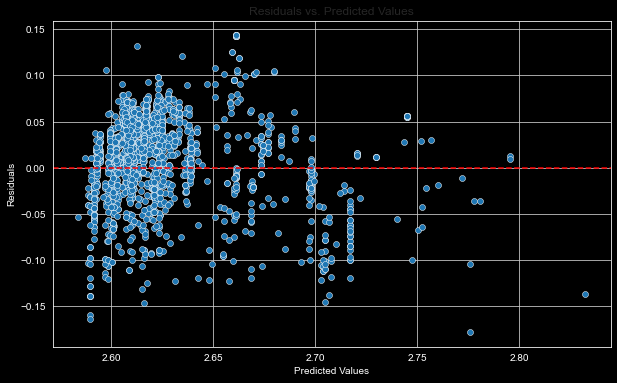

In [14]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10,6))
sns.scatterplot(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

## Conclusion

**1. Performance Metrics:**

- R^2 (Coefficient of Determination): The Linear Regression model has an R^2 value of 0.60, suggesting that it explains 60% of the variance in the target variable, which is a relatively decent fit. On the other hand, the SVR model has a low R^2 value of 0.23, indicating it only explains 23% of the variance, which is quite poor.

- Mean Squared Error (MSE): The Linear Regression model's MSE of 0.27 is considerably higher than the SVR's 0.0. A lower MSE suggests that the SVR's predictions are closer to the actual values, on average, compared to the Linear Regression model.

**2. Residual Plots:** 

**Support Vector Regression Model:** 

The residuals display a noticeable "U" shaped pattern, suggesting potential non-linear relationships in the data that the SVR model may not be capturing.
The residuals have a wider spread, indicating higher variability in the errors.

**Linear Regression Model:** 

The residuals are more centered around the zero line and are more clustered, suggesting the predictions are generally more accurate and consistent.
There's less of a discernible pattern in the residuals, although a slight curvature suggests there could be minor non-linearities.